# Imports

In [17]:
import pydot
import graphviz
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, concatenate, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from keras.layers import dot
from tensorflow.keras.utils import plot_model

2021-08-28 12:12:09.711786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-28 12:12:09.711850: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

In [29]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Dataset

In [5]:
dataset = pd.read_csv('../data/processed_data/active_users_df_10PlusRatings_partial.csv')
anime_df = pd.read_csv('../data/raw_data/anime.csv')
dataset = dataset.sort_values(["user_id", "anime_id"], ascending=(True, True))

In [6]:
dataset.anime_id.nunique()

12106

In [7]:
dataset.user_id.nunique()

4035

# Order dataset by user_id and anime_id

In [8]:
anime_id_to_new_id = dict()
id = 1

In [9]:
%%time
for index, row in dataset.iterrows():
    if anime_id_to_new_id.get(row['anime_id']) is None:
        anime_id_to_new_id[row['anime_id']] = id
        dataset.at[index, 'anime_id'] = id
        id += 1
    else:
        dataset.at[index, 'anime_id'] = anime_id_to_new_id.get(row['anime_id'])


In [10]:
%%time
user_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if user_id_to_new_id.get(row['user_id']) is None:
        user_id_to_new_id[row['user_id']] = id
        dataset.at[index, 'user_id'] = id
        id += 1
    else:
        dataset.at[index, 'user_id'] = user_id_to_new_id.get(row['user_id'])


In [11]:
dataset.user_id

3            1
4            1
0            1
9            1
14           1
          ... 
822308    4035
822416    4035
822372    4035
822305    4035
822356    4035
Name: user_id, Length: 822418, dtype: int64

In [12]:
num_users = len(dataset.user_id.unique())
num_animes = len(dataset.anime_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_animes)
print('Number of users', num_users)

Number of movies 12106
Number of users 4035


In [22]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (657934, 3)
test shape:  (164484, 3)


# GMF


## Matrix factorisation

In [26]:
# Let's use a higher latent dimension.
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)
from keras.layers import dot
prod = dot([anime_vec, user_vec], axes=1, normalize=False)



2021-08-28 12:00:54.196779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-28 12:00:54.196914: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-28 12:00:54.196951: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TVGBETP): /proc/driver/nvidia/version does not exist
2021-08-28 12:00:54.197405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
print('user_input',user_input.shape)
print('anime_input',anime_input.shape)

user_input (None, 1)
anime_input (None, 1)


In [28]:
model_MF = Model([user_input, anime_input], prod)
model_MF.compile('adam', 'mean_squared_error'
              #,metrics=['mse']
             )

In [29]:
model_MF.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anime-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime-embedding (Embedding)     (None, 1, 10)        121070      anime-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        40360       user-input[0][0]                 
______________________________________________________________________________________________

In [30]:
dataset.rating = dataset.rating.astype(float)

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model_MF.fit([train.user_id, train.anime_id], train.rating, epochs=4)

2021-08-28 12:00:58.808389: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
20561/20561 [==============================] - 84s 4ms/step - loss: 21.0143
Epoch 2/4
20561/20561 [==============================] - 81s 4ms/step - loss: 3.0719
Epoch 3/4
20561/20561 [==============================] - 76s 4ms/step - loss: 2.2948
Epoch 4/4
20561/20561 [==============================] - 75s 4ms/step - loss: 2.0651


In [ ]:
plot_model(model_MF, show_shapes=True)

In [ ]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

# Neural network with MF 

## MF + Multilayer model

In [13]:
# Matrix factorization
latent_dim = 10

anime_input = Input(shape=[1],name='anime-input')
anime_embedding = Embedding(num_animes + 1, latent_dim, name='anime-embedding')(anime_input)
anime_vec = Flatten(name='anime-flatten')(anime_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)
from keras.layers import dot
prod = dot([anime_vec, user_vec], axes=1, normalize=False)

2021-08-28 12:15:39.074174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-28 12:15:39.074306: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-28 12:15:39.074339: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TVGBETP): /proc/driver/nvidia/version does not exist
2021-08-28 12:15:39.074697: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Adding NN upon MF

prod_dropout = Dropout(0.2)(prod)
fc_1 = Dense(100, name='fc-1', activation='relu')(prod)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='relu')(fc_2_dropout)


model = Model([user_input, anime_input], fc_3)
model.compile(optimizer=Adam(lr=0.1), loss = 'mean_squared_error')

/home/ka_wagon/.pyenv/versions/anime_map/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


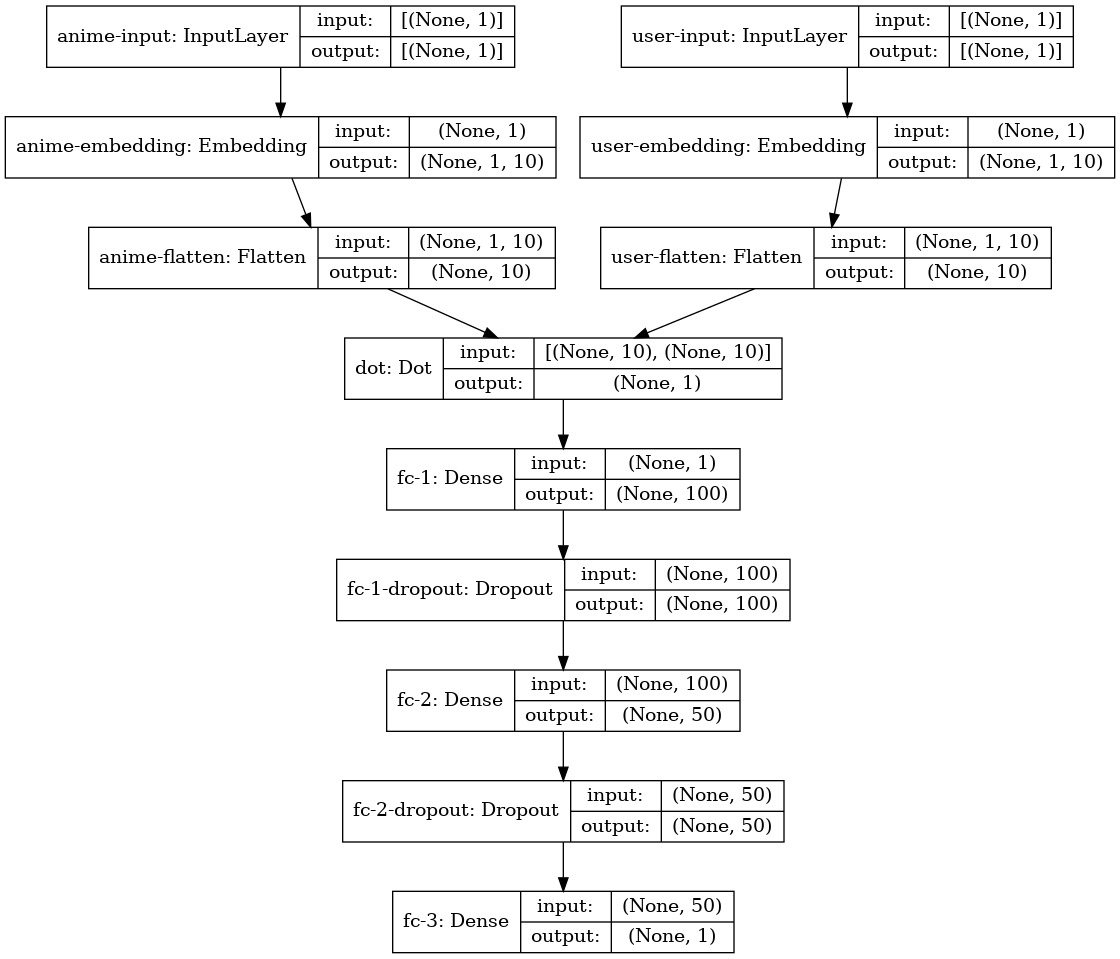

In [16]:
plot_model(model, show_shapes=True)

In [20]:
%%time
history = model.fit([train.user_id, train.anime_id], train.rating, epochs=5)

2021-08-28 12:16:50.361262: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
20561/20561 [==============================] - 90s 4ms/step - loss: 3.3244
Epoch 2/5
20561/20561 [==============================] - 95s 5ms/step - loss: 3.1260
Epoch 3/5
20561/20561 [==============================] - 86s 4ms/step - loss: 3.1233
Epoch 4/5
20561/20561 [==============================] - 88s 4ms/step - loss: 3.1236
Epoch 5/5
20561/20561 [==============================] - 84s 4ms/step - loss: 3.1242


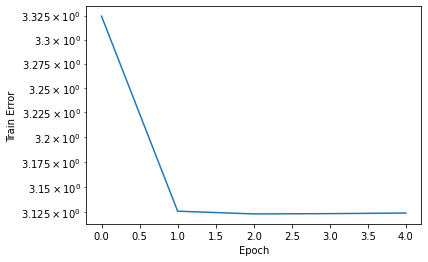

1.3850411057851997

In [22]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.anime_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

In [27]:
test.user_id

386974    1841
65561      336
766523    3784
699002    3426
143307     692
          ... 
660676    3215
334182    1570
776773    3839
667553    3257
533142    2581
Name: user_id, Length: 164484, dtype: int64

In [28]:
test.anime_id

386974      64
65561      957
766523    1848
699002     355
143307    3316
          ... 
660676     928
334182     239
776773     474
667553    1523
533142     353
Name: anime_id, Length: 164484, dtype: int64

In [26]:
y_hat

array([[7.37],
       [7.37],
       [7.37],
       ...,
       [7.37],
       [7.37],
       [7.37]], dtype=float32)